# Clustering the Beaded Helix With Non-Uniform Frame Weights

## Import Libraries

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import MDAnalysis as md
# import shapeGMM
from shapeGMMTorch import torch_sgmm
from shapeGMMTorch import scripts
# import pytorch
import torch

## Read trajectory

In [2]:
prmtopFileName = "helix_template.pdb"
trajFileName = "helix_folding_eps6.0.dcd"
coord = md.Universe(prmtopFileName,trajFileName)
print("Number of atoms in trajectory:", coord.atoms.n_atoms)
print("Number of frames in trajectory:", coord.trajectory.n_frames)
# make atom selection
atomSel = coord.select_atoms('all')
print("Number of atoms in selection:", atomSel.n_atoms)
# create traj data of selection
traj_data = np.empty((coord.trajectory.n_frames,atomSel.n_atoms,3),dtype=float)
#loop traj
for ts in coord.trajectory:
    traj_data[ts.frame,:] = atomSel.positions

Number of atoms in trajectory: 12
Number of frames in trajectory: 10001
Number of atoms in selection: 12


## Perform Cross Validation with Uniform Weights

Here we will perform a cluster scan assuming each frame has the same weight.  This is exactly what we did in the other notebook.

In [3]:
# define cluster array
cluster_array = np.arange(1,7,1).astype(int)

In [6]:
# uniform weights
train, cv = scripts.cross_validate_cluster_scan(traj_data, 2000, covar_type="kronecker", cluster_array = cluster_array, n_training_sets=3, n_attempts = 5, dtype=torch.float32, device=torch.device("cpu"))

Number of frames to train each model: 2000
Number of frames to predict each model: 8001
Number of training sets: 3
Number of clusters: 6
Number of attempts per set/cluster: 5
   Training Set      N Clusters         Attempt  Log Like per Frame    CPU Time (s)
------------------------------------------------------------------------------------
              1               1               1              35.826           2.386
              1               1               2              35.826           2.199
              1               1               3              35.826           2.219
              1               1               4              35.826           2.183
              1               1               5              35.826           2.136
              1               2               1              40.384           6.807
              1               2               2              39.297          33.295
              1               2               3              40.326 

## Perform Cross Validation with ENM Weights for each Frame

I have calculated the weight of each frame of this trajectory assuming it came from an ENM model.  This should bias towards only finding the right- and left-handed helices and ignoring anything else.  

In [7]:
# load the weights
frame_weights = np.loadtxt("enm_weights.dat")
print(np.sum(frame_weights))

1.0


In [8]:
# CV scan with non-uniform weights
enm_train, enm_cv = scripts.cross_validate_cluster_scan(traj_data, 2000, frame_weights = frame_weights, covar_type="kronecker", cluster_array = cluster_array, n_training_sets=3, n_attempts = 5, dtype=torch.float32, device=torch.device("cpu"))

Number of frames to train each model: 2000
Number of frames to predict each model: 8001
Number of training sets: 3
Number of clusters: 6
Number of attempts per set/cluster: 5
   Training Set      N Clusters         Attempt  Log Like per Frame    CPU Time (s)
------------------------------------------------------------------------------------
              1               1               1              43.198          18.216
              1               1               2              43.198          17.829
              1               1               3              43.198          17.715
              1               1               4              43.198          17.977
              1               1               5              43.198          18.025
              1               2               1              48.296           3.844
              1               2               2              48.296           3.094
              1               2               3              48.296 

## Perform Cross-Validation with Random Weights for each Frame

In [9]:
# load the weights
random_frame_weights = np.random.rand(frame_weights.shape[0])
random_frame_weights /= np.sum(random_frame_weights)

In [10]:
# CV scan with non-uniform weights
random_train, random_cv = scripts.cross_validate_cluster_scan(traj_data, 2000, frame_weights = random_frame_weights, covar_type="kronecker", cluster_array = cluster_array, n_training_sets=3, n_attempts = 5, dtype=torch.float32, device=torch.device("cpu"))

Number of frames to train each model: 2000
Number of frames to predict each model: 8001
Number of training sets: 3
Number of clusters: 6
Number of attempts per set/cluster: 5
   Training Set      N Clusters         Attempt  Log Like per Frame    CPU Time (s)
------------------------------------------------------------------------------------
              1               1               1              36.048          23.548
              1               1               2              36.048          23.702
              1               1               3              36.048          23.550
              1               1               4              36.048          23.556
              1               1               5              36.048          23.606
              1               2               1              39.200          40.011
              1               2               2              40.098           7.539
              1               2               3              39.781 

## Make Log Likelihood vs number of Cluster Plots

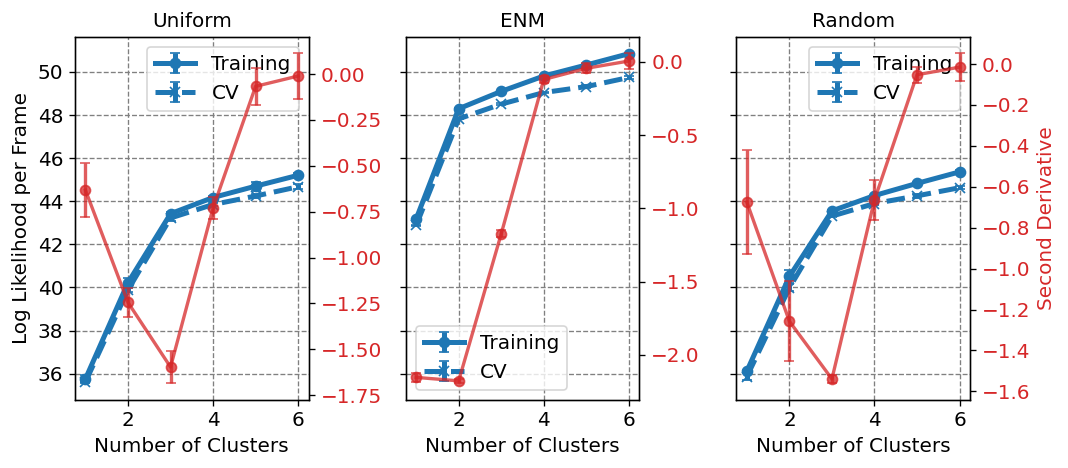

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_log_likelihood_with_dd(axis,cluster_array,train_log_lik,valid_log_lik,fontsize=16,xlabel=True,ylabel1=True,ylabel2=True):
    colors = ["tab:blue", "tab:red"]
    # Training Data
    train_mean = np.mean(train_log_lik,axis=1)
    train_std = np.std(train_log_lik,axis=1)
    axis.errorbar(cluster_array,train_mean,train_std,fmt='-o',lw=3,capsize=3,c=colors[0],label="Training")
    # Validation
    valid_mean = np.mean(valid_log_lik,axis=1)
    valid_std = np.std(valid_log_lik,axis=1)
    axis.errorbar(cluster_array,valid_mean,valid_std,fmt='--x',lw=3,capsize=3,c=colors[0],label="CV")
    # Second derivative
    ax2 = axis.twinx()
    n_samples = train_log_lik.shape[1]
    n_clusters = train_log_lik.shape[0]
    dd = np.empty(train_log_lik.shape)
    for sample in range(n_samples):
        dd[:,sample] = np.gradient(np.gradient(train_log_lik[:,sample]))
    dd_mean = np.mean(dd,axis=1)
    dd_std = np.std(dd,axis=1)
    ax2.errorbar(cluster_array,dd_mean,dd_std,fmt='-o',lw=2,capsize=3,alpha=0.75,c=colors[1])
    #
    axis.grid(which='major', axis='both', color='#808080', linestyle='--')
    if ylabel1==True:
        axis.set_ylabel("Log Likelihood per Frame",fontsize=fontsize)
    if ylabel2==True:
        ax2.set_ylabel("Second Derivative",fontsize=fontsize,color=colors[1])
    if xlabel==True:
        axis.set_xlabel("Number of Clusters",fontsize=fontsize)
    ax2.tick_params(axis='both',labelsize=fontsize,labelcolor=colors[1])
    axis.tick_params(axis='both',labelsize=fontsize)
    axis.legend(fontsize=fontsize)
    
# create figure
fig, ax = plt.subplots(1,3,figsize=(9,4), dpi= 120, facecolor='w', edgecolor='k',sharex=True,sharey=True)
# Uniform Weights
ax[0].set_title("Uniform",fontsize=12)
plot_log_likelihood_with_dd(ax[0],cluster_array,train,cv,fontsize=12,ylabel1=True,ylabel2=False,xlabel=True)
# ENM Weights
ax[1].set_title("ENM",fontsize=12)
plot_log_likelihood_with_dd(ax[1],cluster_array,enm_train,enm_cv,fontsize=12,ylabel1=False,ylabel2=False,xlabel=True)
# Random Weights
ax[2].set_title("Random",fontsize=12)
plot_log_likelihood_with_dd(ax[2],cluster_array,random_train,random_cv,fontsize=12,ylabel1=False,ylabel2=True,xlabel=True)
# show plot
plt.tight_layout()
plt.show()

## Fit a $n_clusters=2$ object with ENM weights

In [28]:
import sys
import time
def sgmm_fit_with_attempts(train_data, n_clusters, n_attempts, frame_weights = [], covar_type='kronecker', dtype=torch.float32, device=torch.device("cuda:0")):
    """
    Initialize and fit shapeGMM object with training data but do so a number of times and return the max log likelihood object

    Arguments:
        train_data (required)   - (n_train_frames,n_atoms,3) float array containing training data
        n_clusters (required)   - integer number of clusters must be input
        n_attempts (required)   - integer dictating the number of random intializations to attempt
        frame_weights (optional)- (n_train_frames) float array containing relative frame weights.  Defaults to empty (uniform weights)
        covar_type              - string defining the covariance type.  Options are 'kronecker' and 'uniform'.  Defualt is 'kronecker'.
        dtype                   - Data type to be used.  Default is torch.float32.
        device                  - device to be used.  Default is torch.device('cuda:0') device.

    Returns:
        shapeGMM object with max log likelhood from attempts
    """
    # meta data from input array
    n_frames = traj_data.shape[0]
    # set parameters
    print("Number of training frames:", n_frames)
    print("Number of clusters:", n_clusters)
    print("Number of attempts:", n_attempts)
    sys.stdout.flush()
    objs = []
    log_likes = []
    # print log info
    print("%8s %19s %15s" % ("Attempt", "Log Like per Frame","CPU Time (s)"))
    print("%50s" % ("--------------------------------------------------"))
    #
    for i in range(n_attempts):
        start_time = time.process_time()
        wsgmm = torch_sgmm.ShapeGMMTorch(n_clusters,covar_type=covar_type, dtype=dtype, device=device)
        wsgmm.fit(train_data, frame_weights = frame_weights)
        elapsed_time = time.process_time()-start_time
        print("%8d %19.3f %15.3f" % (i+1, np.round(wsgmm.log_likelihood,3), np.round(elapsed_time,3)))
        objs.append(wsgmm)
        log_likes.append(wsgmm.log_likelihood)
    # return obj with max log likelihood per frame
    return objs[np.argmax(log_likes)]

In [29]:
# fit an shapeGMM object for n=2 with ENM weights
sgmm_enm_weights = sgmm_fit_with_attempts(traj_data[::2], 2, 10, frame_weights[::2],device=torch.device("cpu"))

Number of training frames: 10001
Number of clusters: 2
Number of attempts: 10
 Attempt  Log Like per Frame    CPU Time (s)
--------------------------------------------------
       1              48.084           5.914
       2              44.111          35.920
       3              48.085           5.148
       4              48.085           4.820
       5              48.084           6.791
       6              48.085           5.100
       7              48.085           5.143
       8              48.077           5.568
       9              48.074          11.600
      10              44.196          53.638
